## L3: Entity Identification

In [1]:
import pandas as pd
import numpy as np 
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
#loading the english language model
NER = spacy.load('en_core_web_sm')

There are several methods of extracting relationships like from text, simple rule based methods to advanced deep learning models. But as discussed earlier, most deep learning models are often trained on specific datasets like research papers on drug discoveries. For this project, I will be using NER or Named Entity Recognition.

The steps being carried out here as follows:

1. Tokenization: Every book in the series is tokenized into a list of sentences and then labeled by any name that comes in them. 

2. Identification of window size of how far two sentences are far apart from each other and if two characters are mentioned in these two sentences then there might be some relation between them.



## Load all the text files/books

In [4]:
import os

#accessing directory to get the book files
all_books = [b for b in os.scandir('data') if '.txt' in b.name]

In [5]:
all_books

[<DirEntry '1 The Last Wish.txt'>,
 <DirEntry '2 The Sword of Destiny.txt'>,
 <DirEntry '3  Blood of Elves.txt'>,
 <DirEntry '4 Times of Contempt.txt'>,
 <DirEntry '5 Baptism of Fire.txt'>,
 <DirEntry '6 The Tower of the Swallow.txt'>,
 <DirEntry '7 something ends something begins.txt'>,
 <DirEntry '8 The Lady of the Lake.txt'>]

In [6]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

I have used the function read() and then used the English language model stored in NER to capture any entities in that text

In [7]:
#visualizing the identified entities
displacy.render(book_doc[0:1500], style="ent", jupyter=True)

It is visible that Spacy was successful in capturing alot of the desired entities in this text and in the code I wanted to see the first 1500 entities it had captured, because the text file is rather long. The best part is that whatever entity has been identified is tagged with what kind of an entity it is, like org for organization, person for person etc.

#### L4: Named Entity List
##### Loading the Characters

In [8]:
#read the characters
character_df = pd.read_csv("characters.csv") 

In [9]:
character_df

book               character
0      Category:Baptism of Fire characters                  Adalia
1      Category:Baptism of Fire characters                   Adela
2      Category:Baptism of Fire characters           Aen Saevherne
3      Category:Baptism of Fire characters                Aevenien
4      Category:Baptism of Fire characters                  Aglaïs
...                                    ...                     ...
1270  Category:Time of Contempt characters        Yanna of Murivel
1271  Category:Time of Contempt characters           Yarpen Zigrin
1272  Category:Time of Contempt characters  Yennefer of Vengerberg
1273  Category:Time of Contempt characters         Yiolenta Suarez
1274  Category:Time of Contempt characters                   Zyvik

[1275 rows x 2 columns]

As seen here, some characters have brackets with some sort of labellings to indicate their significance or the role to the context. However we don't want that in the character names. So I will now preprocess that:

In [10]:
import re

# Removing brackets and text within brackets
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
#detecting the characters in betwene them and replacing it with an empty string 
#if not detected, return the original value

# Splitting the character names into first name and the rest of the text
character_df['character_fname'] = character_df['character'].apply(lambda x: x.split(" ", 1)[0])
#[0] picks the first element and thus splits it from the rest of the elements
#this column will thus have just the first name of the person


So as observed the desired changes have been made.

In [11]:
character_df

book               character  \
0      Category:Baptism of Fire characters                  Adalia   
1      Category:Baptism of Fire characters                   Adela   
2      Category:Baptism of Fire characters           Aen Saevherne   
3      Category:Baptism of Fire characters                Aevenien   
4      Category:Baptism of Fire characters                  Aglaïs   
...                                    ...                     ...   
1270  Category:Time of Contempt characters        Yanna of Murivel   
1271  Category:Time of Contempt characters           Yarpen Zigrin   
1272  Category:Time of Contempt characters  Yennefer of Vengerberg   
1273  Category:Time of Contempt characters         Yiolenta Suarez   
1274  Category:Time of Contempt characters                   Zyvik   

     character_fname  
0             Adalia  
1              Adela  
2                Aen  
3           Aevenien  
4             Aglaïs  
...              ...  
1270           Yanna  
1271          Yarpen  
1272        Yennefer  
1273        Yiolenta  
1274           Zyvik  

[1275 rows x 3 columns]

###### Getting named entity list per sentence

In [12]:
sent_entity_df = []
#loop through the sentences, then store the NE list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence":sent, "entities":entity_list})
    
#converting the findings into a dataframe again
sent_entity_df = pd.DataFrame(sent_entity_df)

In [13]:
pd.set_option('display.max_rows', None)
sent_entity_df

sentence  \
0      (ï»¿The, Limits, of, the, Possible, \n, I, \n,...   
1      (", It, 's, been, an, hour, and, a, quarter, s...   
2                                 (He, 's, done, for, .)   
3      (", \n, The, townsfolk, ,, huddled, together, ...   
4      (A, fat, man, dressed, in, a, yellow, smock, \...   
5      (", We, have, to, wait, a, bit, longer, ,, ", ...   
6      (", Why, wait, ?, ", snorted, pimply, ,, ", Th...   
7      (Anyone, goes, down, there, ,, that, 's, the, ...   
8      (Have, you, forgotten, how, many, \n, have, di...   
9      (What, are, we, waiting, for, ?, ", \n, ", Thi...   
10         (murmured, the, fat, man, uncertainly, ., \n)   
11     (", An, agreement, you, made, with, a, living,...   
12     (", He, is, now, dead, ,, as, surely, as, the,...   
13     (It, was, plain, from, the, beginning, that, h...   
14     (He, did, n't, even, take, a, mirror, with, hi...   
15     (", \n, ", At, least, we, 've, saved, some, co...   
16                   (You, might, as, well, go, home, .)   
17     (As, far, as, the, sorcerer, 's, horse, and, b...   
18     (well, it, \n, would, be, a, shame, if, they, ...   
19     (", \n, ", Yes, ,, ", said, the, butcher, ,, "...   
20                           (Let, 's, take, a, look, .)   
21     (", \n, ", What, are, you, doing, ?, ", \n, ",...   
22     (Do, n't, get, in, the, way, unless, you, want...   
23     (", A, fine, old, mare, ,, ", repeated, the, b...   
24      (", Leave, the, horse, alone, ,, my, darling, .)   
25     (", \n, The, butcher, slowly, turned, around, ...   
26     (The, stranger, had, thick, curly, brown, hair...   
27                         (He, had, no, weapons, ., \n)   
28     (3, \n, ", Step, away, from, the, horse, ,, ",...   
29                          (", What, have, we, here, ?)   
30     (A, horse, and, saddlebags, belonging, to, ano...   
31     (Is, that, honourable, ?, ", \n, Pimply, slowl...   
32     (The, butcher, gave, a, nod, and, signalled, t...   
33     (Both, carried, heavy, clubs, ,, like, those, ...   
34     (", Who, are, you, ?, ", demanded, the, pimply...   
35                (", \n, ", You, carry, no, weapons, .)   
36     (", \n, ", That, 's, true, ,, ", the, stranger...   
37     (", \n, ", That, 's, no, good, ,, ", pimply, d...   
38     (", \n, The, butcher, also, drew, a, blade, ;,...   
39     (The, other, two, men, approached, ,, brandish...   
40     (", I, do, n't, carry, weapons, ,, ", responde...   
41     (", \n, From, behind, the, ruins, ,, two, youn...   
42     (The, crowd, quickly, parted, ,, retreated, th...   
43     (The, girls, smiled, ,, flashing, their, teeth...   
44     (They, had, blue, stripes, tattooed, from, the...   
45     (Lynx, pelt, clad, their, strong, muscles, fro...   
46     (From, behind, the, mail, -, clad, shoulder, o...   
47     (Pimply, got, down, on, one, knee, and, slowly...   
48     (From, the, hole, in, ruins, came, a, rumble, ...   
49     (Following, the, hands, ,, a, white, head, app...   
50               (A, murmur, escaped, the, crowd, ., \n)   
51     (The, alabaster, -, haired, man, straightened,...   
52     (Holding, the, beast, by, its, long, lizard, -...   
53     (The, burgrave, jumped, backwards, and, trippe...   
54     (Its, slashed, throat, ,, once, carmine, ,, wa...   
55              (Its, sunken, eyes, were, glassy, ., \n)   
56     (", Here, 's, the, basilisk, ,, ", said, the, ...   
57     (I, will, check, them, ,, I, 'm, warning, you, .)   
58     (", \n, 4, \n, With, shaking, hands, ,, the, b...   
59     (The, white, -, haired, man, looked, around, a...   
60     (He, also, noticed, the, man, in, the, brown, ...   
61     (", It, 's, always, the, same, ,, ", he, said,...   
62     (You, people, never, change, ,, damn, you, to,...   
63     (", \n, ", We, have, n't, touched, your, bags,...   
64     (The, men, armed, with, the, clubs, had, long,...   
65     (", Your, things, have, not, been, disturbed, ...   
66     (At, the, sight, of, 

Through the above loop, the entities have now been listed post being recognized as SpaCy had done above. However, since this relationship extraction is only between characters, entities like organizations, places etc. must be filtered out. After that, it is possible to create relationships, which is the next level in this project.

In [14]:
#function to filter out non-character entities
def filter_ent(ent_list, character_df):
    return [ent for ent in ent_list
           if ent in list(character_df.character)
           or ent in list(character_df.character_fname)]

In [15]:
#testing for the same
filter_ent(['Geralt', 'Gloomy', '4'], character_df)

['Geralt']

As seen here, only the recognized "character" has been recognized, regardless of whether or not "Gloomy" or "4" even exists in the dataset or not.

In [16]:
sent_entity_df['character_entities']=sent_entity_df['entities'].apply(lambda x: filter_ent(x, character_df))

In [17]:
sent_entity_df

sentence  \
0      (ï»¿The, Limits, of, the, Possible, \n, I, \n,...   
1      (", It, 's, been, an, hour, and, a, quarter, s...   
2                                 (He, 's, done, for, .)   
3      (", \n, The, townsfolk, ,, huddled, together, ...   
4      (A, fat, man, dressed, in, a, yellow, smock, \...   
5      (", We, have, to, wait, a, bit, longer, ,, ", ...   
6      (", Why, wait, ?, ", snorted, pimply, ,, ", Th...   
7      (Anyone, goes, down, there, ,, that, 's, the, ...   
8      (Have, you, forgotten, how, many, \n, have, di...   
9      (What, are, we, waiting, for, ?, ", \n, ", Thi...   
10         (murmured, the, fat, man, uncertainly, ., \n)   
11     (", An, agreement, you, made, with, a, living,...   
12     (", He, is, now, dead, ,, as, surely, as, the,...   
13     (It, was, plain, from, the, beginning, that, h...   
14     (He, did, n't, even, take, a, mirror, with, hi...   
15     (", \n, ", At, least, we, 've, saved, some, co...   
16                   (You, might, as, well, go, home, .)   
17     (As, far, as, the, sorcerer, 's, horse, and, b...   
18     (well, it, \n, would, be, a, shame, if, they, ...   
19     (", \n, ", Yes, ,, ", said, the, butcher, ,, "...   
20                           (Let, 's, take, a, look, .)   
21     (", \n, ", What, are, you, doing, ?, ", \n, ",...   
22     (Do, n't, get, in, the, way, unless, you, want...   
23     (", A, fine, old, mare, ,, ", repeated, the, b...   
24      (", Leave, the, horse, alone, ,, my, darling, .)   
25     (", \n, The, butcher, slowly, turned, around, ...   
26     (The, stranger, had, thick, curly, brown, hair...   
27                         (He, had, no, weapons, ., \n)   
28     (3, \n, ", Step, away, from, the, horse, ,, ",...   
29                          (", What, have, we, here, ?)   
30     (A, horse, and, saddlebags, belonging, to, ano...   
31     (Is, that, honourable, ?, ", \n, Pimply, slowl...   
32     (The, butcher, gave, a, nod, and, signalled, t...   
33     (Both, carried, heavy, clubs, ,, like, those, ...   
34     (", Who, are, you, ?, ", demanded, the, pimply...   
35                (", \n, ", You, carry, no, weapons, .)   
36     (", \n, ", That, 's, true, ,, ", the, stranger...   
37     (", \n, ", That, 's, no, good, ,, ", pimply, d...   
38     (", \n, The, butcher, also, drew, a, blade, ;,...   
39     (The, other, two, men, approached, ,, brandish...   
40     (", I, do, n't, carry, weapons, ,, ", responde...   
41     (", \n, From, behind, the, ruins, ,, two, youn...   
42     (The, crowd, quickly, parted, ,, retreated, th...   
43     (The, girls, smiled, ,, flashing, their, teeth...   
44     (They, had, blue, stripes, tattooed, from, the...   
45     (Lynx, pelt, clad, their, strong, muscles, fro...   
46     (From, behind, the, mail, -, clad, shoulder, o...   
47     (Pimply, got, down, on, one, knee, and, slowly...   
48     (From, the, hole, in, ruins, came, a, rumble, ...   
49     (Following, the, hands, ,, a, white, head, app...   
50               (A, murmur, escaped, the, crowd, ., \n)   
51     (The, alabaster, -, haired, man, straightened,...   
52     (Holding, the, beast, by, its, long, lizard, -...   
53     (The, burgrave, jumped, backwards, and, trippe...   
54     (Its, slashed, throat, ,, once, carmine, ,, wa...   
55              (Its, sunken, eyes, were, glassy, ., \n)   
56     (", Here, 's, the, basilisk, ,, ", said, the, ...   
57     (I, will, check, them, ,, I, 'm, warning, you, .)   
58     (", \n, 4, \n, With, shaking, hands, ,, the, b...   
59     (The, white, -, haired, man, looked, around, a...   
60     (He, also, noticed, the, man, in, the, brown, ...   
61     (", It, 's, always, the, same, ,, ", he, said,...   
62     (You, people, never, change, ,, damn, you, to,...   
63     (", \n, ", We, have, n't, touched, your, bags,...   
64     (The, men, armed, with, the, clubs, had, long,...   
65     (", Your, things, have, not, been, disturbed, ...   
66     (At, the, sight, of, 

In [18]:
#filtering out the sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len)>0]
sent_entity_df_filtered.head(10)

sentence  \
85                       (I, am, Geralt, of, Rivia, .)   
95   (Is, there, anything, keeping, you, in, this, ...   
102  (", \n, ", Borch, ,, ", replied, Geralt, ,, wh...   
106  (", \n, ", There, are, some, ,, ", Geralt, rep...   
110  (", \n, Geralt, took, off, a, glove, and, shoo...   
140  (", I, forgot, ,, ", Three, Jackdaws, winked, ...   
151  (Geralt, loosened, his, belt, ,, removed, his,...   
157  (", Do, the, girls, speak, the, common, langua...   
160  (How, 's, your, soup, ,, Geralt, ?, ", \n, ", ...   
169  (Yet, there, is, a, certain, principal, underl...   

                     entities character_entities  
85          [Geralt of Rivia]  [Geralt of Rivia]  
95          [Geralt of Rivia]  [Geralt of Rivia]  
102           [Borch, Geralt]           [Geralt]  
106                  [Geralt]           [Geralt]  
110                  [Geralt]           [Geralt]  
140  [Three Jackdaws, Geralt]           [Geralt]  
151                  [Geralt]           [Geralt]  
157                  [Geralt]           [Geralt]  
160             [Geralt, Hmm]           [Geralt]  
169                  [Geralt]           [Geralt]

Now here it is visible that only those sentences are visible wherein the name of the character is visible.

In [19]:
#taking only the first name of characters
sent_entity_df_filtered['character_entities']=sent_entity_df_filtered['character_entities'].apply(lambda x:[item.split()[0]
                                                                                                           for item in x])

C:\Users\hi\AppData\Local\Temp/ipykernel_4316/1176723627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities']=sent_entity_df_filtered['character_entities'].apply(lambda x:[item.split()[0]


In [20]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

sentence  \
85                         (I, am, Geralt, of, Rivia, .)   
95     (Is, there, anything, keeping, you, in, this, ...   
102    (", \n, ", Borch, ,, ", replied, Geralt, ,, wh...   
106    (", \n, ", There, are, some, ,, ", Geralt, rep...   
110    (", \n, Geralt, took, off, a, glove, and, shoo...   
...                                                  ...   
11314  (He, only, saw, black, -, gloved, hands, squee...   
11316                                 (Oh, ,, Geralt, !)   
11321                            (Say, it, ,, Geralt, !)   
11322  (Forever, !, Say, it, !, ", \n, ", Forever, ,,...   
11327  (", \n, Yurga, saw, astonishment, in, the, eye...   

                      entities character_entities  
85           [Geralt of Rivia]           [Geralt]  
95           [Geralt of Rivia]           [Geralt]  
102            [Borch, Geralt]           [Geralt]  
106                   [Geralt]           [Geralt]  
110                   [Geralt]           [Geralt]  
...                        ...                ...  
11314                   [Ciri]             [Ciri]  
11316                 [Geralt]           [Geralt]  
11321                 [Geralt]           [Geralt]  
11322  [Forever, Ciri, Geralt]     [Ciri, Geralt]  
11327                  [Yurga]            [Yurga]  

[1696 rows x 3 columns]

#### L5: Create Relationships

As explained earlier, in order to explain the relationship existence between characters, I talked about "Window Size" wherein 5 sentences are included within one rolling window. So as studied, I will begin with making a rolling window, and thus identify all the characters that appear in the same window.

In [21]:
window_size=5 

for i in range(sent_entity_df_filtered.index[-1]):
    #for i in range of the last index
    
    #READ: end_i = i + 5
    
    #taking the next 5 entities
    #however we have to eb careful because the 
    #total number of indices might not be a multiple of 5 thus it throws error so
    
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    #just calling the sum function and merging it with an empty list
    char_list = sum((sent_entity_df_filtered.loc[i:end_i].character_entities), [])
    
    if i>200 and i<300:
        print(char_list)
    


[]
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt', 'Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
[]
[]
[]
[]
[]
[]
[]
[]
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt', 'Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
[]
[]
[]
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
['Geralt']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Geralt']
['Geralt']
['Geralt', 'Geralt']
['Geralt', 'Geralt']


There are quite a few duplicates here, so it does not make sense to look for relationship with a character with the character himself. So just removing those duplicated characters next to each other.

In [22]:
window_size=5 

#initializing an empty list for the rels 
relationships =[]

for i in range(sent_entity_df_filtered.index[-1]):
    #for i in range of the last index
    
    #READ: end_i = i + 5
    
    #taking the next 5 entities
    #however we have to eb careful because the 
    #total number of indices might not be a multiple of 5 thus it throws error so
    
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    #just calling the sum function and merging it with an empty list
    char_list = sum((sent_entity_df_filtered.loc[i:end_i].character_entities), [])
    
    #removal
    char_unique = [char_list[i] for i in range(len(char_list))
                  if (i==0) or char_list[i] != char_list[i-1]]
    
    #now if we have the name of a character who has more than 1 element, then the first 
    #element will be the source of the relationship and the target will be the second element 
    if len(char_unique)> 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx+1]
            relationships.append({"source":a, "target":b})
        
        #this should be the iteration for only the second last character becayse if we increment the index by 1, 
        #we basically will be exceeding the max index
        

In [23]:
relationship_df = pd.DataFrame(relationships)

In [24]:
pd.set_option('display.max_rows', None)
relationship_df.head(10)

source    target
0    Geralt  Niedamir
1    Geralt  Niedamir
2    Geralt  Niedamir
3  Niedamir    Geralt
4  Niedamir    Geralt
5  Niedamir    Geralt
6    Geralt  Niedamir
7    Geralt  Niedamir
8  Niedamir    Geralt
9  Niedamir    Geralt

Again, there are a lot of duplicates in this dataframe which can be aggregated into one. Aggregating these sources and targets will tell us which of the relationships are the most important/how strong the relationship is and this will be achieved using the concept of weights.

In [25]:
#sorting the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), columns = relationship_df.columns)
relationship_df

source             target
0                Geralt           Niedamir
1                Geralt           Niedamir
2                Geralt           Niedamir
3                Geralt           Niedamir
4                Geralt           Niedamir
5                Geralt           Niedamir
6                Geralt           Niedamir
7                Geralt           Niedamir
8                Geralt           Niedamir
9                Geralt           Niedamir
10               Geralt           Niedamir
11               Geralt           Niedamir
12                 Eyck             Geralt
13                 Eyck             Geralt
14                 Eyck             Geralt
15                 Eyck             Geralt
16                 Eyck             Geralt
17                 Eyck             Geralt
18                 Eyck             Geralt
19                 Eyck             Geralt
20                 Eyck             Geralt
21                 Eyck             Geralt
22                 Eyck             Geralt
23               Geralt           Niedamir
24               Geralt           Niedamir
25               Geralt           Niedamir
26               Geralt           Niedamir
27               Geralt           Niedamir
28           Dorregaray             Geralt
29           Dorregaray             Geralt
30           Dorregaray           Yennefer
31           Dorregaray           Yennefer
32           Dorregaray           Yennefer
33           Dorregaray           Yennefer
34           Dorregaray           Yennefer
35           Dorregaray           Yennefer
36           Dorregaray             Geralt
37           Dorregaray           Yennefer
38           Dorregaray             Geralt
39               Geralt             Yarpen
40               Geralt             Yarpen
41               Geralt             Yarpen
42               Geralt       Gyllenstiern
43               Geralt       Gyllenstiern
44               Geralt       Gyllenstiern
45               Geralt       Gyllenstiern
46               Geralt           Niedamir
47               Geralt       Gyllenstiern
48               Geralt           Niedamir
49               Geralt       Gyllenstiern
50               Geralt           Niedamir
51               Boholt           Niedamir
52               Boholt             Geralt
53               Boholt             Geralt
54               Geralt             Kennet
55               Geralt             Kennet
56               Boholt             Kennet
57               Boholt             Kennet
58               Boholt             Kennet
59               Boholt             Kennet
60               Boholt             Geralt
61               Geralt             Yarpen
62               Geralt             Yarpen
63               Geralt             Yarpen
64               Geralt             Yarpen
65               Geralt             Yarpen
66               Yarpen           Yennefer
67               Yarpen           Yennefer
68               Yarpen           Yennefer
69             Niedamir           Yennefer
70         Gyllenstiern           Niedamir
71         Gyllenstiern           Niedamir
72         Gyllenstiern           Yennefer
73         Gyllenstiern           Niedamir
74         Gyllenstiern           Yennefer
75         Gyllenstiern           Niedamir
76         Gyllenstiern           Yennefer
77         Gyllenstiern           Niedamir
78         Gyllenstiern           Yennefer
79         Gyllenstiern           Niedamir
80         Gyllenstiern           Yennefer
81               Boholt           Yennefer
82               Boholt           Yennefer
83               Boholt           Yennefer
84               Boholt           Yennefer
85               Boholt           Yennefer
86               Boholt           Yennefer
87               Boholt           Yennefer
88               Boholt             Yarpen
89               Boholt           Yennefer
90               Boholt             Yarpen
91               Boholt           Yennefer
92               B

In [26]:
relationship_df["value"]=1 
relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index=False).sum()

In [27]:
relationship_df.head(10)

source        target  value
0      Geralt      Niedamir     52
1        Eyck        Geralt     51
2  Dorregaray        Geralt     30
3  Dorregaray      Yennefer     44
4      Geralt        Yarpen     24
5      Geralt  Gyllenstiern     32
6      Boholt      Niedamir     21
7      Boholt        Geralt     39
8      Geralt        Kennet      2
9      Boholt        Kennet      8

#### L6: Graph Analysis and Visualization

In [28]:
#create a graph via the pandas dataframe
G1 = nx.from_pandas_edgelist(relationship_df,
                            source = "source",
                            target = "target",
                            edge_attr = "value",
                            create_using= nx.Graph())

#edgelist is something that contains the variables source and target, which is something we just created above.


##### Graph Visualization using Networkx
---
For enabling this one needs the module Scipy which can be installed in the terminal upon activation of the virtual environment and then using the pip3 command.

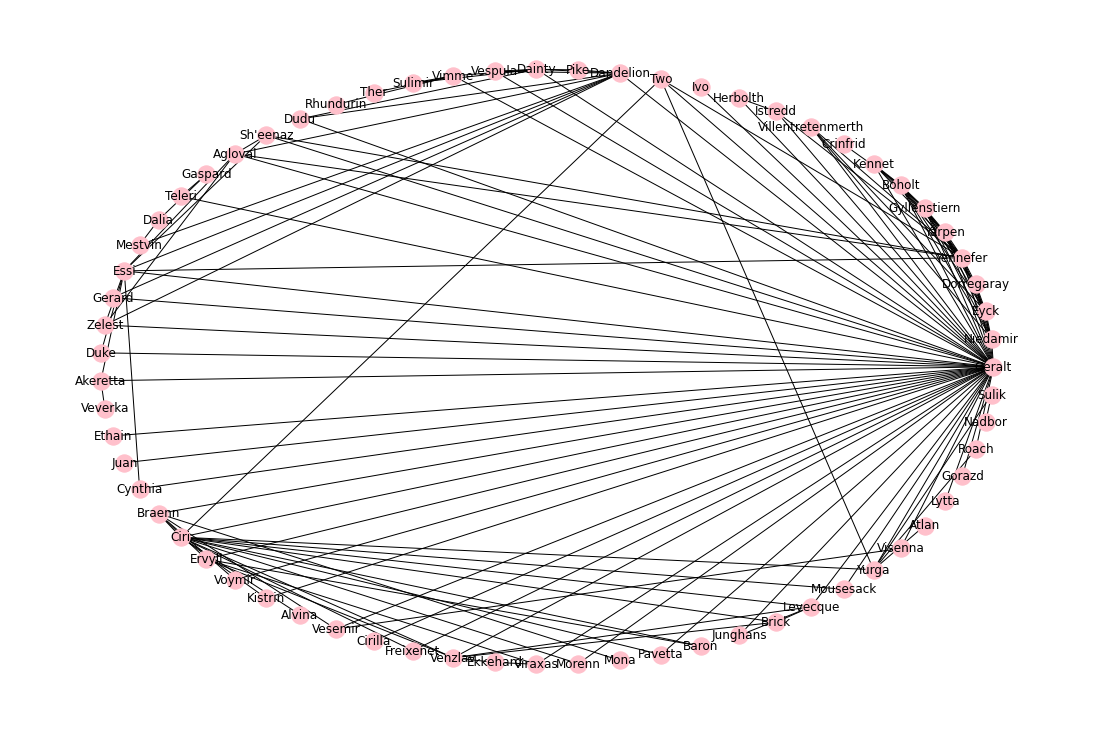

In [29]:
#for my graph I will be using kamada_kawai and draw_circular
plt.figure(figsize=(15, 10))
pos = nx.circular_layout(G1)
nx.draw(G1, with_labels=True, node_color='pink', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

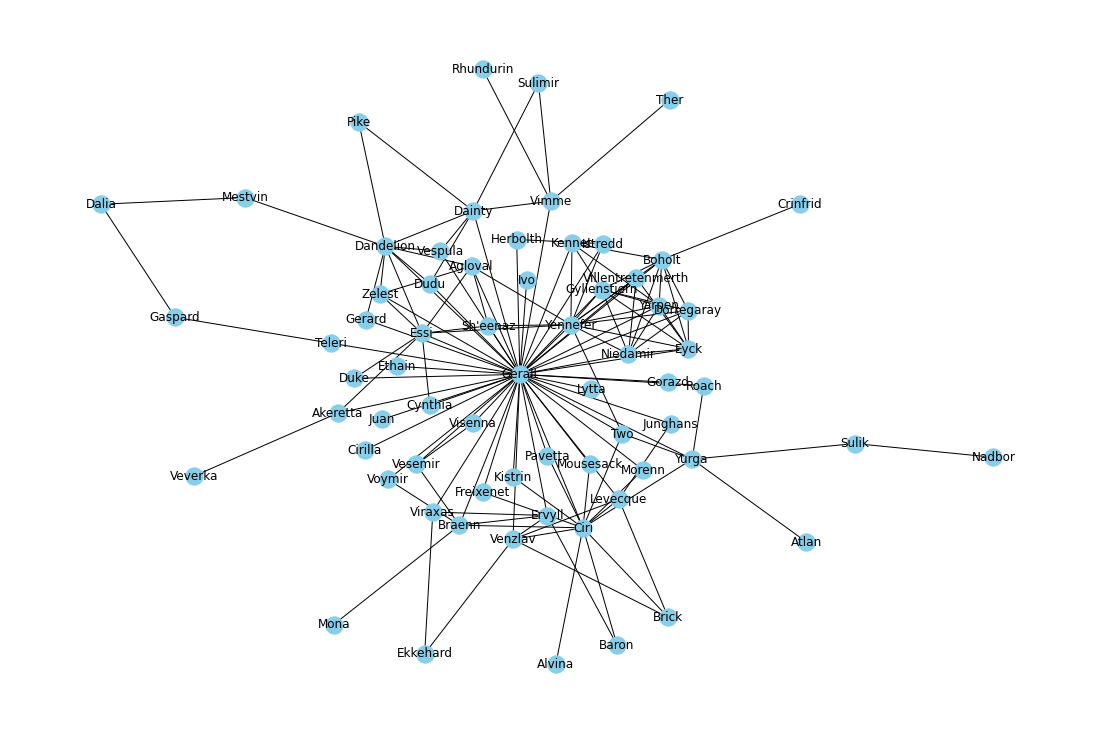

In [30]:
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(G1)
nx.draw(G1, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

Both of these graphs are not the best visualizations because they are cluttered, too tiny, the distinctions and discretions are unclear among many other reasons. It lacks interactivity to differentiate between sources and targets. So for this part I will make this more efficient.

---

This is where <b>Pyvis</b> comes into the picture and help me to visualize the graphs better.

##### Graph Visualization using Pyvis

In [31]:
from pyvis.network import Network
net = Network(notebook=True, width = "700px", height="500px", bgcolor = '#222222', font_color='white')
net.from_nx(G1)
net.show("witcher.html")

witcher.html


This is so much cooler and nicer!

---
 However, I would customize the node size because we want to be able to see the main characters and details like that, based on the degrees of the node. The degree of the node is defined as the number of connections the node has, which the Networkx library has already done.

In [32]:
from pyvis.network import Network
net = Network(notebook=True, width = "700px", height="500px", bgcolor = '#222222', font_color='white')

node_degree = dict(G1.degree)

#setting up node size attribute
nx.set_node_attributes(G1, node_degree, 'size')
net.from_nx(G1)
net.show("witchernode.html")

witchernode.html


From this graph it is visible that Geralt, Yennefer, Dandelion and Ciri have some of the highest node sizes based on the number of relationships they have.

In [33]:
#printing out the dictionary for each of the weights
dict(G1.degree)

#so here we can see that 'Geralt' has the highest occurance/weight so accordingly the node size attribute will be set up

{'Geralt': 49,
 'Niedamir': 8,
 'Eyck': 8,
 'Dorregaray': 6,
 'Yennefer': 14,
 'Yarpen': 7,
 'Gyllenstiern': 8,
 'Boholt': 9,
 'Kennet': 5,
 'Crinfrid': 1,
 'Villentretenmerth': 4,
 'Istredd': 3,
 'Herbolth': 2,
 'Ivo': 1,
 'Two': 4,
 'Dandelion': 10,
 'Pike': 2,
 'Dainty': 7,
 'Vespula': 3,
 'Vimme': 5,
 'Sulimir': 2,
 'Ther': 1,
 'Rhundurin': 1,
 'Dudu': 3,
 "Sh'eenaz": 4,
 'Agloval': 6,
 'Gaspard': 2,
 'Teleri': 2,
 'Dalia': 2,
 'Mestvin': 2,
 'Essi': 9,
 'Gerard': 2,
 'Zelest': 4,
 'Duke': 2,
 'Akeretta': 3,
 'Veverka': 1,
 'Ethain': 1,
 'Juan': 1,
 'Cynthia': 2,
 'Braenn': 6,
 'Ciri': 14,
 'Ervyll': 5,
 'Voymir': 2,
 'Kistrin': 2,
 'Alvina': 1,
 'Vesemir': 3,
 'Cirilla': 1,
 'Freixenet': 2,
 'Venzlav': 6,
 'Ekkehard': 2,
 'Viraxas': 3,
 'Morenn': 2,
 'Mona': 1,
 'Pavetta': 2,
 'Baron': 2,
 'Junghans': 2,
 'Brick': 3,
 'Levecque': 5,
 'Mousesack': 2,
 'Yurga': 6,
 'Visenna': 2,
 'Atlan': 1,
 'Lytta': 1,
 'Gorazd': 1,
 'Roach': 2,
 'Nadbor': 1,
 'Sulik': 2}

This concept is based upon what's called <b>Degree Centrality</b>. It is based upon the assumption that the nodes which have the most connections are the most important nodes. But centrality measures also consider other measures such as "Best Closeness Centrality", and
"Highest Eigenvector Centrality" etc. Let's explore the most important characters based on the centrality of betweenness, or mutuals that act as bridges between two or more different groups.

##### Which are the most important characters in The Witcher??

In [34]:
#degree centrality
degree_dict = nx.degree_centrality(G1)
degree_dict

{'Geralt': 0.7424242424242424,
 'Niedamir': 0.12121212121212122,
 'Eyck': 0.12121212121212122,
 'Dorregaray': 0.09090909090909091,
 'Yennefer': 0.21212121212121213,
 'Yarpen': 0.10606060606060606,
 'Gyllenstiern': 0.12121212121212122,
 'Boholt': 0.13636363636363635,
 'Kennet': 0.07575757575757576,
 'Crinfrid': 0.015151515151515152,
 'Villentretenmerth': 0.06060606060606061,
 'Istredd': 0.045454545454545456,
 'Herbolth': 0.030303030303030304,
 'Ivo': 0.015151515151515152,
 'Two': 0.06060606060606061,
 'Dandelion': 0.15151515151515152,
 'Pike': 0.030303030303030304,
 'Dainty': 0.10606060606060606,
 'Vespula': 0.045454545454545456,
 'Vimme': 0.07575757575757576,
 'Sulimir': 0.030303030303030304,
 'Ther': 0.015151515151515152,
 'Rhundurin': 0.015151515151515152,
 'Dudu': 0.045454545454545456,
 "Sh'eenaz": 0.06060606060606061,
 'Agloval': 0.09090909090909091,
 'Gaspard': 0.030303030303030304,
 'Teleri': 0.030303030303030304,
 'Dalia': 0.030303030303030304,
 'Mestvin': 0.030303030303030304,


<AxesSubplot:>

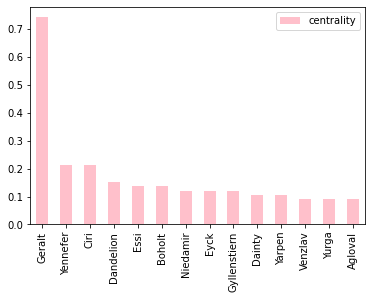

In [35]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

#plotting upto 14 nodes
degree_df.sort_values('centrality', ascending=False)[0:14].plot(kind='bar', color = "pink")

So as mentioned earlier, Geralt, Yennefer and Ciri look like the main characters, and the graph says the same.

<AxesSubplot:>

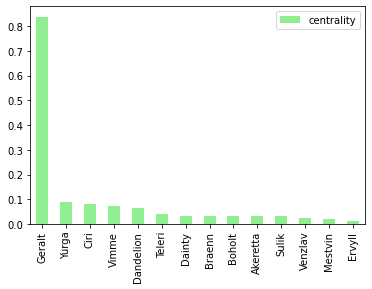

In [36]:
#testing for betweenness centrality:
betweenness_dict = nx.betweenness_centrality(G1)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
#plot 15 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:14].plot(kind='bar', color='lightgreen')

Here, Geralt remains to be listed but in terms of mutuality but Dandelion and Yennefer have not lasted. It is Yuga and Ciri now!

<AxesSubplot:>

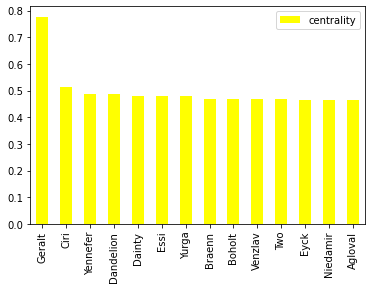

In [37]:
#closeness centrality
closeness_dict = nx.closeness_centrality(G1)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
#plot 15 nodes
closeness_df.sort_values('centrality', ascending=False)[0:14].plot(kind='bar', color='yellow')

Again, most nodes tend to have the shortest distance from the character Geralt and the order follows. It is clearly a very dense network!

In [38]:
#saving these centrality measures
nx.set_node_attributes(G1, degree_dict, 'degree_centrality')
nx.set_node_attributes(G1, degree_dict, 'betweenness_centrality')
nx.set_node_attributes(G1, degree_dict, 'closeness_centrality')

These centrality measures can be used for community measures to understand different communities, their importance that changes over time, their relevance to the context and whatnot. Such measures are highly significant and functional to answer a lot of the questions which pretty much go hand-in-hand with historical analysis too!

---

In order to detect communities, there are various community detection algorithms like Louvain for example, which I will use as learnt, and thus demonstrated as shown:

##### Community Detection

In [39]:
!pip install python-louvain

In [40]:
import community as community_louvain

In [41]:
communities = community_louvain.best_partition(G1)

In [42]:
communities

{'Geralt': 0,
 'Niedamir': 1,
 'Eyck': 1,
 'Dorregaray': 1,
 'Yennefer': 1,
 'Yarpen': 1,
 'Gyllenstiern': 1,
 'Boholt': 1,
 'Kennet': 1,
 'Crinfrid': 1,
 'Villentretenmerth': 1,
 'Istredd': 0,
 'Herbolth': 0,
 'Ivo': 0,
 'Two': 3,
 'Dandelion': 4,
 'Pike': 4,
 'Dainty': 4,
 'Vespula': 4,
 'Vimme': 4,
 'Sulimir': 4,
 'Ther': 4,
 'Rhundurin': 4,
 'Dudu': 4,
 "Sh'eenaz": 6,
 'Agloval': 6,
 'Gaspard': 2,
 'Teleri': 2,
 'Dalia': 2,
 'Mestvin': 2,
 'Essi': 6,
 'Gerard': 4,
 'Zelest': 6,
 'Duke': 6,
 'Akeretta': 6,
 'Veverka': 6,
 'Ethain': 0,
 'Juan': 0,
 'Cynthia': 6,
 'Braenn': 0,
 'Ciri': 5,
 'Ervyll': 5,
 'Voymir': 0,
 'Kistrin': 5,
 'Alvina': 5,
 'Vesemir': 0,
 'Cirilla': 0,
 'Freixenet': 5,
 'Venzlav': 5,
 'Ekkehard': 5,
 'Viraxas': 5,
 'Morenn': 5,
 'Mona': 0,
 'Pavetta': 5,
 'Baron': 5,
 'Junghans': 5,
 'Brick': 5,
 'Levecque': 5,
 'Mousesack': 5,
 'Yurga': 3,
 'Visenna': 0,
 'Atlan': 3,
 'Lytta': 0,
 'Gorazd': 0,
 'Roach': 3,
 'Nadbor': 3,
 'Sulik': 3}

Now enabling communities gives a description of which character belongs to which community. So I will now just set these communities as the node attribute. Previously, the node attribute was size, but now it will change to communities.

In [43]:
nx.set_node_attributes(G1, communities, 'group')

Pyvis automatically detects the variation in the node communities and will thus provide different colors to different communities.

In [44]:
commu_net = Network(notebook=True, width="800px", height="600px", bgcolor="#222222", font_color='white')
commu_net.from_nx(G1)
commu_net.show("witchercommunities.html")

witchercommunities.html


So from this vibrant visualization, there are bigger node sizes that represent to which character the community belongs to, so Geralt has one blue community, Yennefer has the yellow one, Ciri has the mustard colored one, Dandelion the green one, so on and so forth.

Now, as a part of one of the simpler objectives, I had mentioned how does the importance of characters evolves over time. To top this project, I will do just that now, as I have learnt.

Here, I will determine the importance of characters that change throughout the book series. So each of the books will be assigned different graphs. Then this can be all plotted into one graph.

##### Evolution of characters' importance

I began with renaming all the book titles as the need is to see the evolution of character importance in a chronological order. I personally have not read these books so after referring the internet I have obtained the order the books are to be read in and that was done.

In [45]:
#initializing empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('data') if '.txt' in b.name]

#sort the directory entreis by name 
all_books.sort(key=lambda x:x.name)

In [46]:
from Lib.utils.functions import *

In [47]:
#loop through the booj list and create graphs
for book in all_books:
    book_text = ner(book)
    
    #get list of entities per sentence
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    #selecting only characters 
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x:filter_entity(x, character_df))
    
    #filtering the sentences that do not have any chars
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len)>0]
    
    #taking only the first name of chars
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x:[item.split()[0]
                                                                                                                 for item in x])
    
    #create relationship df
    relate_df = create_relationships(df = sent_entity_df_filtered, window_size=5)
    
    #create a graph from pandas dataframe
    g = nx.from_pandas_edgelist(relate_df,
                               source="source",
                               target="target",
                               edge_attr="value",
                               create_using=nx.Graph())
    
    books_graph.append(g)

C:\Users\hi\AppData\Local\Temp/ipykernel_4316/3865748635.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x:[item.split()[0]


<AxesSubplot:>

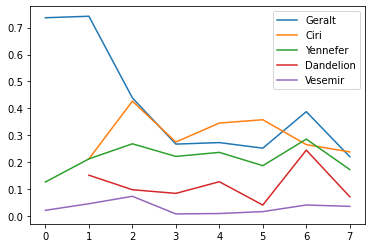

In [48]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Geralt", "Ciri", "Yennefer", "Dandelion", "Vesemir"]].plot()